In [7]:
import pandas as np

In [8]:
!pip install transformers datasets accelerate peft torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import PeftModel, PeftConfig
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
# مسیر مدل فاین‌تیون‌شده (فرض بر اینه که در MyDrive ذخیره شده)
model_path = "/content/drive/MyDrive/xlm_roberta_finetuned_9L"

# فایل‌های پرتورب‌شده‌ی کاراکتری
perturbation_files = {
    "10%": "/content/x_fact_test_charlevel_perturbed_10.csv",
    "30%": "/content/x_fact_test_charlevel_perturbed_30.csv",
    "60%": "/content/x_fact_test_charlevel_perturbed_60.csv"
}

# فایل آموزش برای ساخت LabelEncoder
train_file = "/content/x_fact_train_oversampled_9L.csv"


In [11]:
# لود مدل پایه + LoRA
peft_config = PeftConfig.from_pretrained(model_path)
base_model = AutoModelForSequenceClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=4  # تعداد کلاس‌ها
)
tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)
model = PeftModel.from_pretrained(base_model, model_path)

# تعریف متریک‌ها
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted")
    }

# تعریف Trainer برای ارزیابی
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8,
    logging_dir="./logs"
)
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [12]:
train_df = pd.read_csv(train_file)
label_encoder = LabelEncoder()
label_encoder.fit(train_df["label"])


LabelEncoder()

In [13]:
from collections import defaultdict

language_results = []

def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

for perturb_name, path in perturbation_files.items():
    df = pd.read_csv(path)
    df["label"] = label_encoder.transform(df["label"])
    languages = df["source_language"].unique()

    print(f"\n Evaluating for perturbation: {perturb_name}")
    for lang in languages:
        df_lang = df[df["source_language"] == lang]
        encodings = tokenize_function(df_lang["claim"].tolist())

        dataset = Dataset.from_dict({
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"],
            "labels": df_lang["label"].tolist()
        })

        eval_result = trainer.evaluate(dataset)
        language_results.append({
            "perturbation": perturb_name,
            "language": lang,
            "accuracy": eval_result["eval_accuracy"],
            "f1": eval_result["eval_f1"],
            "recall": eval_result["eval_recall"]
        })

        print(f"Lang: {lang} | Acc: {eval_result['eval_accuracy']:.3f} | F1: {eval_result['eval_f1']:.3f}")

# ذخیره نتایج
lang_results_df = pd.DataFrame(language_results)
lang_results_df.to_csv("/content/lang_level_eval_results.csv", index=False)



 Evaluating for perturbation: 10%


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: reyhaneh-ahani (reyhaneh-ahani-simon-fraser-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Lang: de | Acc: 0.513 | F1: 0.486
Lang: pl | Acc: 0.596 | F1: 0.487
Lang: tr | Acc: 0.357 | F1: 0.329
Lang: ka | Acc: 0.282 | F1: 0.200
Lang: nl | Acc: 0.724 | F1: 0.608
Lang: fr | Acc: 0.200 | F1: 0.200
Lang: es | Acc: 0.174 | F1: 0.117
Lang: si | Acc: 0.778 | F1: 0.681
Lang: fa | Acc: 0.625 | F1: 0.572

 Evaluating for perturbation: 30%
Lang: de | Acc: 0.471 | F1: 0.440
Lang: pl | Acc: 0.587 | F1: 0.456
Lang: tr | Acc: 0.326 | F1: 0.296
Lang: ka | Acc: 0.249 | F1: 0.161
Lang: nl | Acc: 0.621 | F1: 0.567
Lang: fr | Acc: 0.229 | F1: 0.259
Lang: es | Acc: 0.243 | F1: 0.171
Lang: si | Acc: 0.778 | F1: 0.681
Lang: fa | Acc: 0.700 | F1: 0.606

 Evaluating for perturbation: 60%
Lang: de | Acc: 0.450 | F1: 0.424
Lang: pl | Acc: 0.578 | F1: 0.488
Lang: tr | Acc: 0.329 | F1: 0.291
Lang: ka | Acc: 0.274 | F1: 0.183
Lang: nl | Acc: 0.586 | F1: 0.571
Lang: fr | Acc: 0.229 | F1: 0.205
Lang: es | Acc: 0.243 | F1: 0.161
Lang: si | Acc: 0.778 | F1: 0.748
Lang: fa | Acc: 0.725 | F1: 0.609


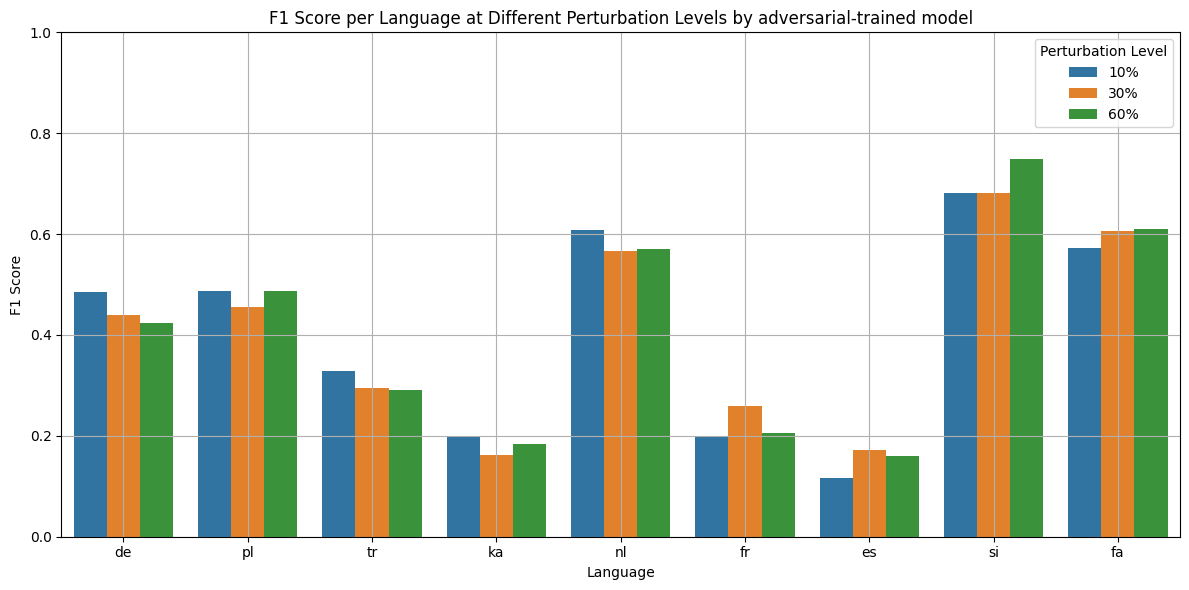

In [14]:
# رسم نمودار F1 بر اساس زبان و سطح نویز
plt.figure(figsize=(12, 6))
sns.barplot(data=lang_results_df, x="language", y="f1", hue="perturbation")
plt.title("F1 Score per Language at Different Perturbation Levels by adversarial-trained model")
plt.ylabel("F1 Score")
plt.xlabel("Language")
plt.ylim(0, 1)
plt.legend(title="Perturbation Level")
plt.grid(True)
plt.tight_layout()
plt.show()


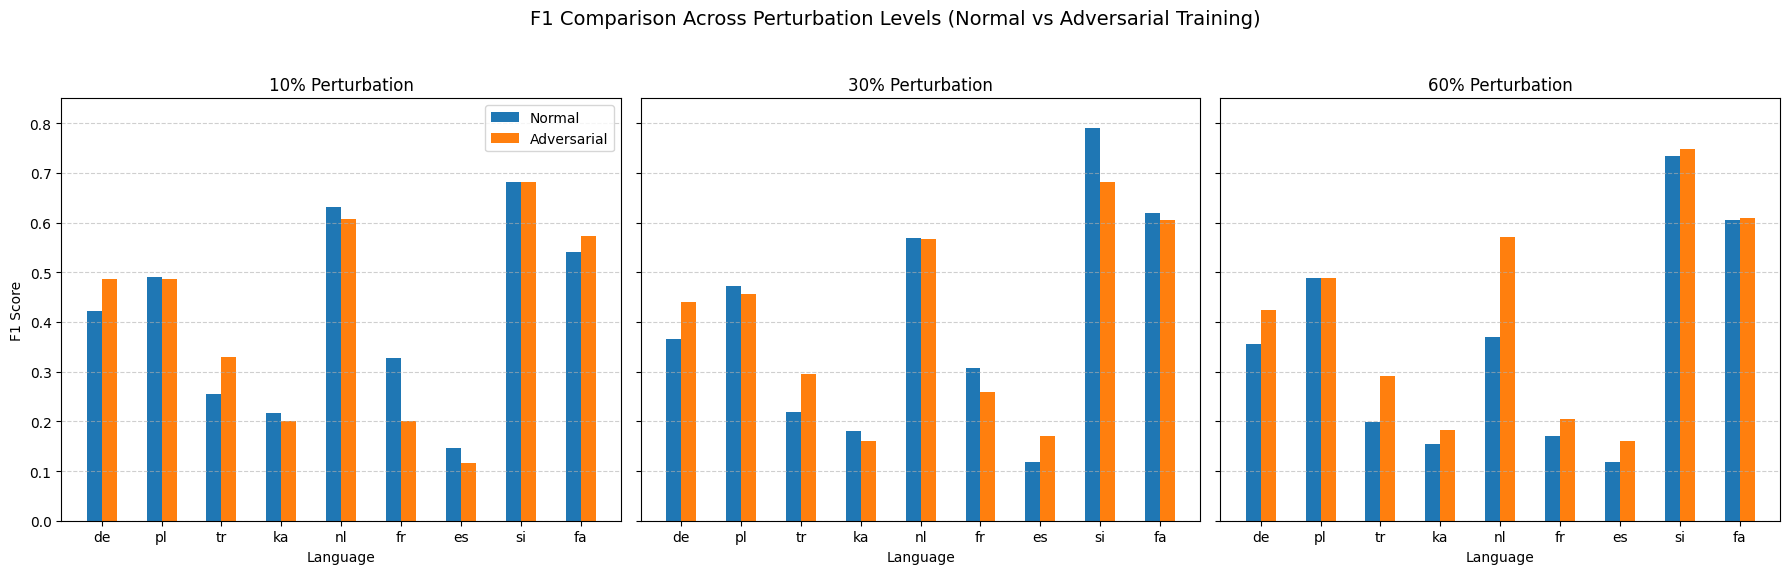

In [15]:
# F1 scores at three perturbation levels for normal and adversarial training
languages = ['de', 'pl', 'tr', 'ka', 'nl', 'fr', 'es', 'si', 'fa']

f1_normal_10 = [0.422, 0.490, 0.255, 0.216, 0.631, 0.327, 0.146, 0.681, 0.541]
f1_normal_30 = [0.366, 0.473, 0.218, 0.181, 0.569, 0.307, 0.118, 0.791, 0.619]
f1_normal_60 = [0.356, 0.488, 0.199, 0.155, 0.370, 0.171, 0.119, 0.733, 0.606]

f1_adv_10 = [0.486, 0.487, 0.329, 0.200, 0.608, 0.200, 0.117, 0.681, 0.572]
f1_adv_30 = [0.440, 0.456, 0.296, 0.161, 0.567, 0.259, 0.171, 0.681, 0.606]
f1_adv_60 = [0.424, 0.488, 0.291, 0.183, 0.571, 0.205, 0.161, 0.748, 0.609]

# Plotting
x = np.arange(len(languages))
width = 0.25

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (perturb_level, normal, adv) in enumerate(zip(
    ['10%', '30%', '60%'],
    [f1_normal_10, f1_normal_30, f1_normal_60],
    [f1_adv_10, f1_adv_30, f1_adv_60]
)):
    axs[i].bar(x - width/2, normal, width, label='Normal')
    axs[i].bar(x + width/2, adv, width, label='Adversarial')
    axs[i].set_title(f'{perturb_level} Perturbation')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(languages)
    axs[i].set_ylim(0, 0.85)
    axs[i].grid(True, axis='y', linestyle='--', alpha=0.6)
    axs[i].set_xlabel('Language')
    if i == 0:
        axs[i].set_ylabel('F1 Score')

plt.suptitle('F1 Comparison Across Perturbation Levels (Normal vs Adversarial Training)', fontsize=14)
axs[0].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


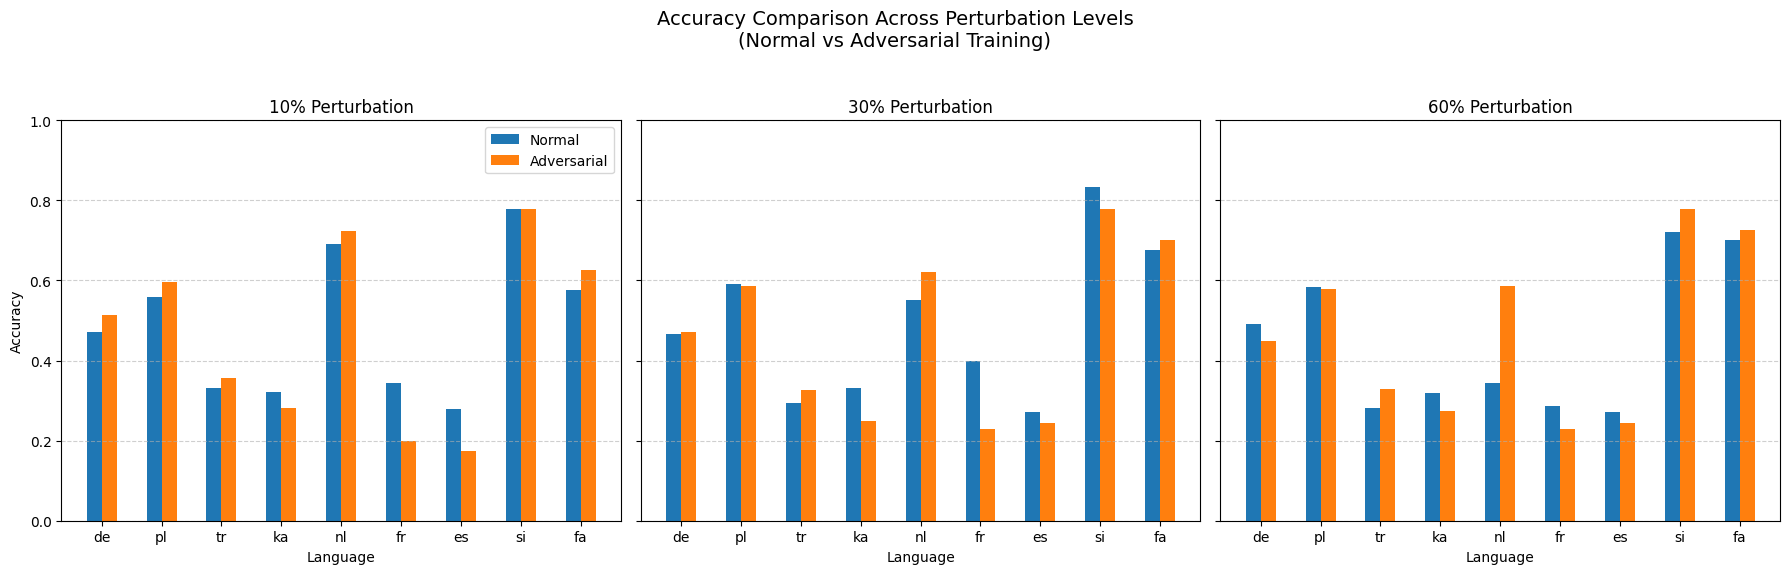

In [16]:
# Re-importing libraries due to kernel reset
import matplotlib.pyplot as plt
import numpy as np

# Accuracy scores at three perturbation levels for normal and adversarial training
languages = ['de', 'pl', 'tr', 'ka', 'nl', 'fr', 'es', 'si', 'fa']

acc_normal_10 = [0.471, 0.560, 0.331, 0.322, 0.690, 0.343, 0.280, 0.778, 0.575]
acc_normal_30 = [0.466, 0.590, 0.294, 0.331, 0.552, 0.400, 0.271, 0.833, 0.675]
acc_normal_60 = [0.492, 0.584, 0.282, 0.320, 0.345, 0.286, 0.271, 0.722, 0.700]

acc_adv_10 = [0.513, 0.596, 0.357, 0.282, 0.724, 0.200, 0.174, 0.778, 0.625]
acc_adv_30 = [0.471, 0.587, 0.326, 0.249, 0.621, 0.229, 0.243, 0.778, 0.700]
acc_adv_60 = [0.450, 0.578, 0.329, 0.274, 0.586, 0.229, 0.243, 0.778, 0.725]

# Plotting
x = np.arange(len(languages))
width = 0.25

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, (perturb_level, normal, adv) in enumerate(zip(
    ['10%', '30%', '60%'],
    [acc_normal_10, acc_normal_30, acc_normal_60],
    [acc_adv_10, acc_adv_30, acc_adv_60]
)):
    axs[i].bar(x - width/2, normal, width, label='Normal')
    axs[i].bar(x + width/2, adv, width, label='Adversarial')
    axs[i].set_title(f'{perturb_level} Perturbation')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(languages)
    axs[i].set_ylim(0, 1.0)
    axs[i].grid(True, axis='y', linestyle='--', alpha=0.6)
    axs[i].set_xlabel('Language')
    if i == 0:
        axs[i].set_ylabel('Accuracy')

plt.suptitle('Accuracy Comparison Across Perturbation Levels\n(Normal vs Adversarial Training)', fontsize=14)
axs[0].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
